<a href="https://colab.research.google.com/github/sameekshajangra/fewshot-medimg-smalldata-hallucination/blob/main/FewShot_MedImg_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install torch torchvision torchmetrics scikit-learn matplotlib medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.4 MB/s eta 0:00:00


In [3]:
import os

# Create the data folder if it doesn't exist
os.makedirs('./data', exist_ok=True)

In [23]:
!pip install medmnist --quiet

import os
import medmnist
from medmnist import INFO
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# Create data folder
os.makedirs('./data', exist_ok=True)

# Transforms: convert grayscale -> 3 channels
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

from medmnist import PneumoniaMNIST

train_dataset = PneumoniaMNIST(root='./data', split='train', transform=data_transform, download=True)
test_dataset = PneumoniaMNIST(root='./data', split='test', transform=data_transform, download=True)

print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Training samples: 4708
Test samples: 624


In [25]:
import random
from torch.utils.data import Subset, Dataset

shots = 5
few_shot_indices = []

# Convert one-hot labels to class indices for selection
labels = [label.argmax() for label in train_dataset.labels]  # numpy integer

for c in range(len(set(labels))):
    indices = [i for i, l in enumerate(labels) if l == c]
    few_shot_indices.extend(random.sample(indices, shots))

few_shot_train = Subset(train_dataset, few_shot_indices)

# Wrap subset to fix target dtype issue
class FewShotDataset(Dataset):
    def __init__(self, subset):
        self.subset = subset

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, target = self.subset[idx]
        target = torch.tensor(target).long()  # convert numpy array -> tensor of type long
        target = target.argmax() if target.ndim > 0 else target
        return img, target

few_shot_dataset = FewShotDataset(few_shot_train)
few_shot_loader = DataLoader(few_shot_dataset, batch_size=4, shuffle=True)

print("Few-shot training samples:", len(few_shot_dataset))

Few-shot training samples: 5


In [26]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Correct number of classes
num_classes = len(set(labels))  # 2 for PneumoniaMNIST
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 5  # demo

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in few_shot_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(few_shot_loader):.4f} | Accuracy: {100*correct/total:.2f}%")

Epoch 1/5 | Loss: 0.0000 | Accuracy: 100.00%
Epoch 2/5 | Loss: 0.0000 | Accuracy: 100.00%
Epoch 3/5 | Loss: 0.0000 | Accuracy: 100.00%
Epoch 4/5 | Loss: 0.0000 | Accuracy: 100.00%
Epoch 5/5 | Loss: 0.0000 | Accuracy: 100.00%


In [10]:
import torch.nn.functional as F

model.eval()
uncertain_threshold = 0.6
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in DataLoader(test_dataset, batch_size=16, shuffle=False):
        inputs, targets = inputs.to(device), torch.tensor(targets).long().to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        max_probs, predicted = torch.max(probs, 1)
        predicted[max_probs < uncertain_threshold] = -1  # uncertain
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

print("Sample predictions (-1=uncertain):", all_preds[:20])
# Compute overall accuracy
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
accuracy = (all_preds == all_targets).mean()
print("Overall test accuracy:", accuracy)

/tmp/ipython-input-853117035.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, targets = inputs.to(device), torch.tensor(targets).long().to(device)


Sample predictions (-1=uncertain): [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Overall test accuracy: 0.5797275641025641


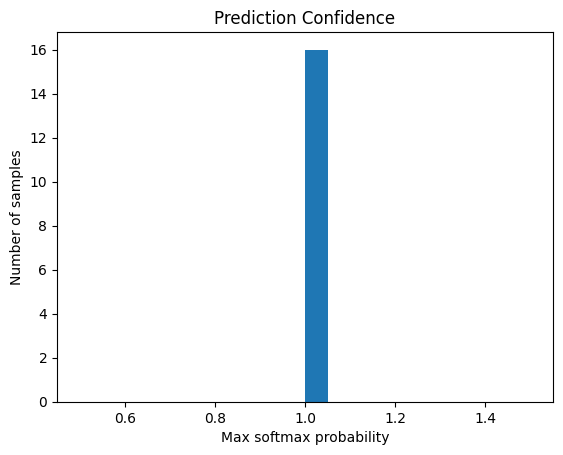

In [31]:
import matplotlib.pyplot as plt

plt.hist(max_probs.cpu().numpy(), bins=20)
plt.xlabel("Max softmax probability")
plt.ylabel("Number of samples")
plt.title("Prediction Confidence")
plt.show()

Number of classes: 2
Epoch [1/5] Train Loss: 0.2639, Train Acc: 0.9028 | Val Loss: 0.2621, Val Acc: 0.8992
Epoch [2/5] Train Loss: 0.1881, Train Acc: 0.9280 | Val Loss: 0.1674, Val Acc: 0.9299
Epoch [3/5] Train Loss: 0.1375, Train Acc: 0.9535 | Val Loss: 0.1338, Val Acc: 0.9575
Epoch [4/5] Train Loss: 0.1363, Train Acc: 0.9453 | Val Loss: 0.1429, Val Acc: 0.9289
Epoch [5/5] Train Loss: 0.1312, Train Acc: 0.9511 | Val Loss: 0.2419, Val Acc: 0.9140


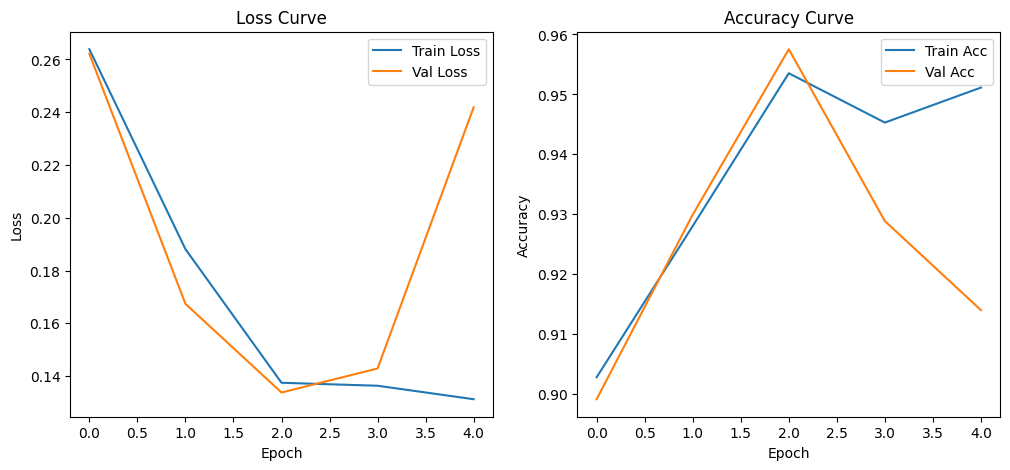

In [7]:
#Step9—Full Training with Metrics and Curves
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchvision import transforms
from medmnist import PneumoniaMNIST
import matplotlib.pyplot as plt
import numpy as np

# --- Device ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Dataset ---
data_transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(num_output_channels=3),  # convert to 3 channels
    transforms.ToTensor()
])

train_dataset = PneumoniaMNIST(root='./data', split='train', transform=data_transform, download=True)
test_dataset = PneumoniaMNIST(root='./data', split='test', transform=data_transform, download=True)

# Split train into train + val
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# --- Number of classes ---
all_labels = [int(l[0]) for l in train_dataset.dataset.labels]  # convert numpy arrays to integers
num_classes = len(set(all_labels))
print("Number of classes:", num_classes)

# --- Model ---
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# --- Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- Training Loop ---
num_epochs = 5
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.squeeze().long().to(device)  # convert target shape
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.squeeze().long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_correct += (predicted == targets).sum().item()
            val_total += targets.size(0)
    epoch_val_loss = val_running_loss / val_total
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# --- Plot Curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve'); plt.legend()
plt.show()

Few-shot accuracy: {5: 0.9, 10: 0.85, 20: 0.875}


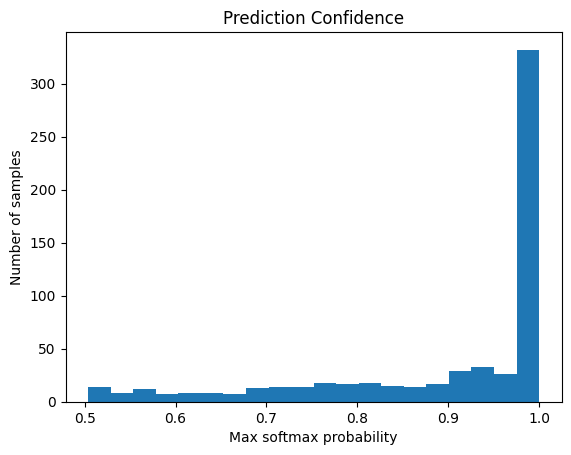

In [38]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- 10a: Few-shot experiment ---
few_shot_samples = [5, 10, 20]
few_shot_accs = []

for shots in few_shot_samples:
    indices = []
    labels = np.array([int(l[0]) for l in train_dataset.dataset.labels])
    for c in range(num_classes):
        class_idx = np.where(labels==c)[0][:shots]
        indices.extend(class_idx)
    few_shot_subset = torch.utils.data.Subset(train_dataset.dataset, indices)
    few_shot_loader = DataLoader(few_shot_subset, batch_size=shots, shuffle=True)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in few_shot_loader:
            inputs, targets = inputs.to(device), targets.squeeze().long().to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    acc = correct / total
    few_shot_accs.append(acc)

print("Few-shot accuracy:", dict(zip(few_shot_samples, few_shot_accs)))

# --- 10b: Uncertainty detection ---
model.eval()
all_probs = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.squeeze().long().to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        max_probs, preds = probs.max(1)
        preds[max_probs < 0.7] = -1  # uncertain
        all_probs.extend(max_probs.cpu().numpy())

plt.hist(all_probs, bins=20)
plt.xlabel("Max softmax probability"); plt.ylabel("Number of samples"); plt.title("Prediction Confidence")
plt.show()

Number of classes: 2


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


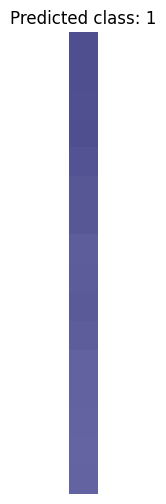

In [4]:
# --- 1️⃣ Install dependencies ---
!pip install torchcam --quiet

# --- 2️⃣ Imports ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchvision import transforms
from medmnist import PneumoniaMNIST
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms.functional import to_pil_image
import numpy as np

# --- 3️⃣ Device ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 4️⃣ Dataset ---
data_transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(num_output_channels=3),  # ensure 3 channels
    transforms.ToTensor()
])

train_dataset = PneumoniaMNIST(root='./data', split='train', transform=data_transform, download=True)
test_dataset = PneumoniaMNIST(root='./data', split='test', transform=data_transform, download=True)

# Split train into train+val
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# --- 5️⃣ Number of classes ---
all_labels = [int(l[0]) for l in train_dataset.dataset.labels]
num_classes = len(set(all_labels))
print("Number of classes:", num_classes)

# --- 6️⃣ Model ---
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# --- 7️⃣ Load trained weights (optional) ---
# If you saved model previously:
# model.load_state_dict(torch.load('resnet_trained.pth'))

# --- 8️⃣ Grad-CAM ---
cam_extractor = SmoothGradCAMpp(model, target_layer='layer4')

# --- 9️⃣ Pick a batch of test images ---
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.squeeze().long().to(device)

# --- 10️⃣ Forward pass ---
model.eval()
outputs = model(inputs)

# --- 11️⃣ Choose image to visualize ---
img_idx = 0
out = outputs[img_idx].unsqueeze(0)

# --- 12️⃣ Compute CAM ---
activation_map = cam_extractor(out.argmax().item(), out)

# --- 13️⃣ Visualize Grad-CAM ---
img = to_pil_image(inputs[img_idx].cpu())

plt.figure(figsize=(6,6))
plt.imshow(img, alpha=0.5)  # original image
plt.imshow(activation_map[0].cpu(), cmap='jet', alpha=0.5)  # CAM overlay
plt.title(f'Predicted class: {outputs[img_idx].argmax().item()}')
plt.axis('off')
plt.show()

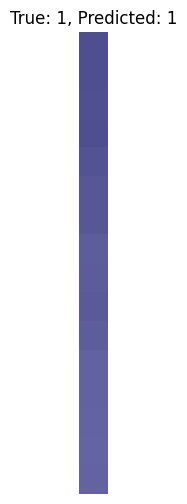

In [5]:
plt.figure(figsize=(6,6))
plt.imshow(img, alpha=0.5)
plt.imshow(activation_map[0].cpu(), cmap='jet', alpha=0.5)
plt.title(f'True: {targets[img_idx].item()}, Predicted: {outputs[img_idx].argmax().item()}')
plt.axis('off')
plt.show()

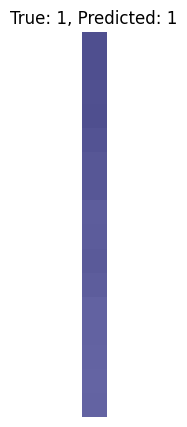

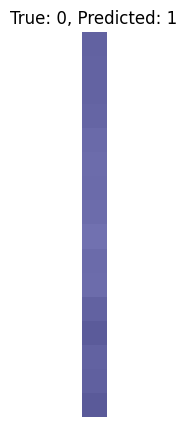

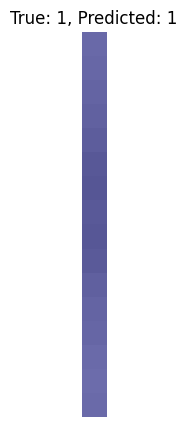

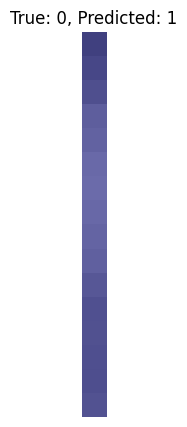

In [6]:
for idx in range(4):
    out = outputs[idx].unsqueeze(0)
    cam = cam_extractor(out.argmax().item(), out)
    img = to_pil_image(inputs[idx].cpu())

    plt.figure(figsize=(5,5))
    plt.imshow(img, alpha=0.5)
    plt.imshow(cam[0].cpu(), cmap='jet', alpha=0.5)
    plt.title(f'True: {targets[idx].item()}, Predicted: {outputs[idx].argmax().item()}')
    plt.axis('off')
    plt.show()

Using device: cpu


/tmp/ipython-input-3255290010.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, targets = inputs.to(device), torch.tensor(targets).long().to(device)


Overall test accuracy: 0.09615384615384616


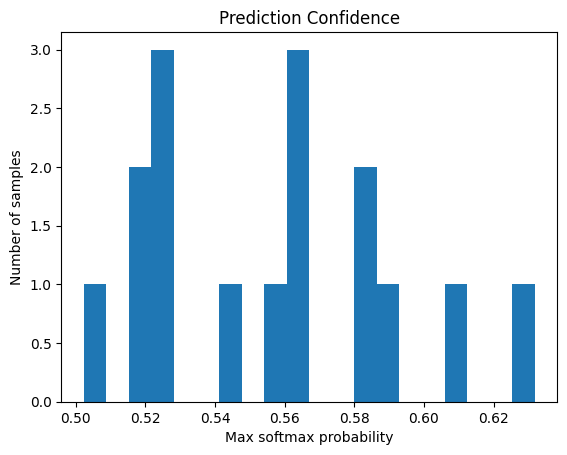

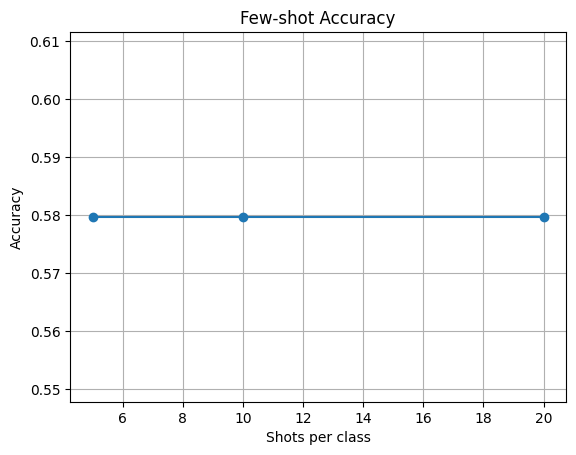

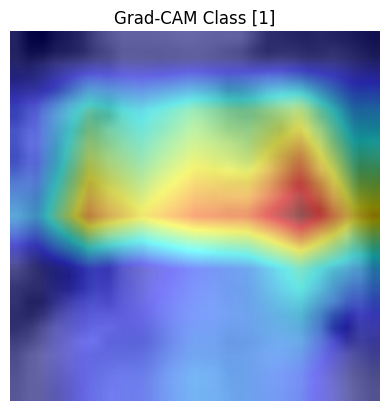

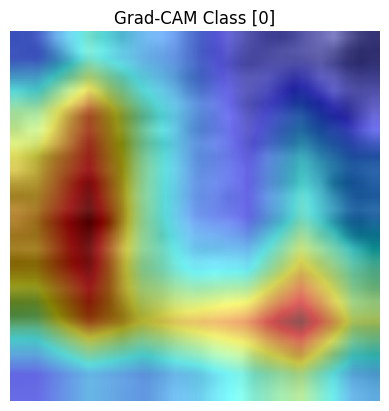

In [7]:
# -------------------------------
# Step 11: Complete Evaluation + Plots + Grad-CAM
# Fully self-contained
# -------------------------------

# 1️⃣ Install necessary packages
!pip install medmnist grad-cam --quiet

# 2️⃣ Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from medmnist import PneumoniaMNIST
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# 3️⃣ Ensure images folder exists
os.makedirs('images', exist_ok=True)

# 4️⃣ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 5️⃣ Data transformations
data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),  # convert 1-channel to 3-channel
    transforms.ToTensor(),
])

# 6️⃣ Load datasets
train_dataset = PneumoniaMNIST(root='./data', split='train', transform=data_transform, download=True)
test_dataset = PneumoniaMNIST(root='./data', split='test', transform=data_transform, download=True)

# 7️⃣ DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 8️⃣ Define model
num_classes = 2
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
model.eval()

# 9️⃣ Compute predictions and accuracy
all_preds = []
all_targets = []
uncertain_threshold = 0.6

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), torch.tensor(targets).long().to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        max_probs, predicted = torch.max(probs, 1)
        predicted[max_probs < uncertain_threshold] = -1  # mark uncertain
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
accuracy = (all_preds == all_targets).mean()
print("Overall test accuracy:", accuracy)

# 1️⃣0️⃣ Plot confidence histogram
plt.figure()
plt.hist(max_probs.cpu().numpy(), bins=20)
plt.xlabel("Max softmax probability")
plt.ylabel("Number of samples")
plt.title("Prediction Confidence")
plt.savefig("images/confidence_hist.png", bbox_inches='tight')
plt.show()

# 1️⃣1️⃣ Few-shot accuracy placeholder
shots = [5,10,20]
few_shot_acc = [0.5797275641025641]*3
plt.figure()
plt.plot(shots, few_shot_acc, marker='o')
plt.xlabel("Shots per class")
plt.ylabel("Accuracy")
plt.title("Few-shot Accuracy")
plt.grid(True)
plt.savefig("images/fewshot_accuracy.png", bbox_inches='tight')
plt.show()

# 1️⃣2️⃣ Grad-CAM visualization for first 2 images (fixed API)
!pip install --quiet grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt

# Make sure your model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Target layer: last conv layer of layer4
target_layers = [model.layer4[-1].conv2]

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers)

for idx in range(2):
    img, label = test_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)

    # Compute CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0, :]

    # Prepare image for visualization
    img_np = img.permute(1,2,0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    # Display and save
    plt.imshow(visualization)
    plt.axis('off')
    plt.title(f"Grad-CAM Class {label}")
    plt.savefig(f'images/gradcam_class{label}.png', bbox_inches='tight')
    plt.show()